## Country flags

### Import packages

In [1]:
import numpy as np

import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import seaborn as sns
import colorsys

### Scrape image sources from wikipedia article

In [2]:
URL = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

sources = soup.find_all('img', class_='thumbborder')
sources[1]

<img alt="" class="thumbborder" data-file-height="900" data-file-width="1350" decoding="async" height="15" src="//upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/23px-Flag_of_India.svg.png" srcset="//upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/35px-Flag_of_India.svg.png 1.5x, //upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/45px-Flag_of_India.svg.png 2x" width="23"/>

In [156]:
sources = soup.find_all('tbody')
entries = sources[0].find_all('tr')[2:]
entry = entries[3]



<td style="text-align:right">271,350,000</td>

### Extract the country information from the scraped source data

In [131]:
def get_flag_url(source):
    src = str(source)
    pos_start = src.find("upload.wikimedia.org/")
    pos_end = src.find(".svg.png")
    url = 'https://' + src[pos_start:pos_end+len(".svg.png")]
    return url

In [125]:
def get_country_name(entry):
    useables = entry.find_all('td')[0:3]
    country_info = useables[0].find_all('a')
    src = str(country_info)
    pos_start = src.find('">') + 2
    pos_end = src.find('</a>')
    return src[pos_start:pos_end]

In [144]:
def get_continent(entry):
    useables = entry.find_all('td')[0:3]
    src = str(useables)
    continents = ['Asia', 'Europe', 'Americas', 'Africa', 'Oceania']
    for continent in continents:
        if continent in src:
            return continent

In [157]:
def get_population(entry):
    useables = entry.find_all('td')[0:3]
    population_info = useables[2]
    src = str(population_info)
    pos_start = src.find('">') + 2
    pos_end = src.find('</td>')
    return src[pos_start:pos_end]

Extracting important information from the data

In [174]:
names = [get_country_name(entry) for entry in entries]
continents = [get_continent(entry) for entry in entries]
populations = [get_population(entry) for entry in entries]
URLs = [get_flag_url(entry) for entry in entries]

Quickly verifying correctness of scraped data

In [176]:
print(len(names), len(continents), len(populations), len(URLs))
for i in 24*np.arange(10):
    print(names[i], continents[i], populations[i])

241 241 241 241
China Asia 1,412,600,000
Italy Europe 59,045,521
Nepal Asia 29,192,480
Zimbabwe Africa 15,790,716
Belarus Europe 9,349,645
Palestine Asia 5,227,193
Botswana Africa 2,410,338
Montenegro Europe 621,306
Grenada Americas 113,000
Liechtenstein Europe 39,151


### Read the images from the URLs and convert them to RGB scale

In [5]:
def get_RGB_colors_from_url(URL):
    response = requests.get(URL)
    img = Image.open(BytesIO(response.content))
    RGB_image = img.convert('RGB')
    width, height = RGB_image.size
    RGB_color = np.empty((width, height, 3))
    for i in range(width):
        for j in range(height):
            RGB_color[i, j, :] = RGB_image.getpixel((i, j))
    return RGB_color

In [6]:
RGB_colors = [get_RGB_colors_from_url(URL) for URL in URLs]

C:\Users\Fabio\Anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Calculate average wavelength

In [7]:
def get_average_wavelength(RGB_color):
    mean_color = np.mean(np.mean(RGB_color, axis=1), axis=0)
    hue = colorsys.rgb_to_hls(mean_color[0], mean_color[1], mean_color[2])
    wavelength = 620 - 170 * hue[0]
    return wavelength

In [282]:
def get_median_wavelength(RGB_color):
    """
    TODO: Function which returns most used color or something
    """

In [195]:
wavelengths = [get_average_wavelength(RGB_color) for RGB_color in RGB_colors]

In [198]:
data_set = np.c_[names, continents, populations, wavelengths]

In [224]:
wavelengths_asia = [float(x[3]) for x in data_set if x[1] == 'Asia']
wavelengths_europe = [float(x[3]) for x in data_set if x[1] == 'Europe']
wavelengths_americas = [float(x[3]) for x in data_set if x[1] == 'Americas']
wavelengths_africa = [float(x[3]) for x in data_set if x[1] == 'Africa']
wavelengths_oceania = [float(x[3]) for x in data_set if x[1] == 'Oceania']

### Average flag colors

<AxesSubplot:ylabel='Density'>

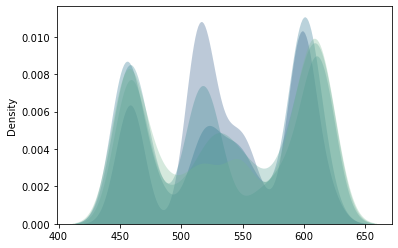

In [289]:
sns.kdeplot(
   data=[wavelengths_asia, wavelengths_europe, wavelengths_americas, wavelengths_africa, wavelengths_oceania],#, x="total_bill", hue="size",
   fill=True, common_norm=False, palette="crest",
   alpha=0.3, linewidth=0.0, bw_method=0.2,
   legend=False
)

### Check Benford's law

<AxesSubplot:ylabel='Count'>

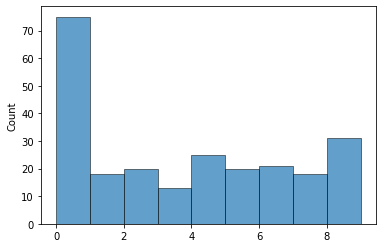

In [281]:
last_digits = [int(x[-1]) for x in populations]
sns.histplot(
   last_digits, bins=range(10),palette="crest",
   alpha=0.7, linewidth=0.5
)